In [40]:
from feat_competition_sales import *

from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import xgboost as xgb

In [41]:
# Tell plotly to plot in a notebook
offline.init_notebook_mode(connected=True)

### Load and plot data

In [42]:
# Load data
store = pd.read_csv('data/store.csv')
train = pd.read_csv('data/train.csv', dtype = {'StateHoliday': np.str})

# Merge
train = pd.merge(store, train, on='Store')
train = date_convert(train)

# Split
end_val = np.floor(0.8 * train.shape[0]).astype(int)
end_test = np.floor(0.9 * train.shape[0]).astype(int)

Train = train.loc[:end_val]
Val = train.loc[end_val:end_test]
Test = train.loc[end_test:]

In [5]:
#plot_hists(train, name='train')

In [ ]:
#plot_hists(store, name='store')

### Feature engineering 

In [43]:
# Clean data, construct new features for xgboost
Train = data_transformation(Train)
Val = data_transformation(Val)
Test = data_transformation(Test)

/home/stas/anaconda3/envs/comp1/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning:

invalid value encountered in log



In [46]:
cols = Train.select_dtypes(include='object').columns.tolist()
for col in cols:
    Train[col] = Train[col].astype(str)
    Val[col] = Val[col].astype(str)
    Test[col] = Test[col].astype(str)
    
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(np.array(Train[cols]))
pickle.dump(ohe, open('metadata/ohe_all.dat', "wb"))

In [6]:
'''
# OHE
cols = Train.select_dtypes(include='object').columns.tolist()

for col in cols:
    Train[col] = Train[col].astype(str)
    Val[col] = Val[col].astype(str)
    Test[col] = Test[col].astype(str)

ohe = OneHotEncoder(handle_unknown='ignore')
ohe_train = pd.DataFrame()
ohe_val = pd.DataFrame()
ohe_test = pd.DataFrame()


for col in cols:
    ohe.fit(np.array(Train[col]).reshape(-1,1))
    ohe_train_tmp = pd.DataFrame(columns=ohe.categories_, \
                                 data=ohe.transform(np.array(Train[col]).reshape(-1,1)).toarray())
    ohe_val_tmp = pd.DataFrame(columns=ohe.categories_, \
                                 data=ohe.transform(np.array(Val[col]).reshape(-1,1)).toarray()) 
    ohe_test_tmp = pd.DataFrame(columns=ohe.categories_, \
                                 data=ohe.transform(np.array(Test[col]).reshape(-1,1)).toarray()) 
    ohe_train = pd.concat([ohe_train, ohe_train_tmp], axis=1)
    ohe_val = pd.concat([ohe_val, ohe_val_tmp], axis=1)
    ohe_test = pd.concat([ohe_test, ohe_test_tmp], axis=1)
'''

In [48]:
ohe_train = ohe.transform(Train[cols]).toarray()
ohe_val = ohe.transform(Val[cols]).toarray()
ohe_test = ohe.transform(Test[cols]).toarray()

In [49]:
# Drop columns
Train.drop(axis=1, labels=cols, inplace=True)
Val.drop(axis=1, labels=cols, inplace=True)
Test.drop(axis=1, labels=cols, inplace=True)

In [57]:
# Concat
Train = pd.concat([Train.reset_index(), pd.DataFrame(ohe_train)], axis=1).drop(axis=1, labels='index')
Val = pd.concat([Val.reset_index(), pd.DataFrame(ohe_val)], axis=1).drop(axis=1, labels='index')
Test = pd.concat([Test.reset_index(), pd.DataFrame(ohe_test)], axis=1).drop(axis=1, labels='index')

In [13]:
# Write data to csv to reuse it fast
#Train.to_csv('data/stasTrain.csv', index=False)
#Test.to_csv('data/stasTest.csv', index=False)
#Val.to_csv('data/stasVal.csv', index=False)

In [34]:
#Train = pd.read_csv('data/stasTrain.csv', index_col=False).drop(axis=1, labels='index')
#Val = pd.read_csv('data/stasVal.csv', index_col=False).drop(axis=1, labels='index')
#Test = pd.read_csv('data/stasTest.csv', index_col=False).drop(axis=1, labels='index')

In [60]:
# Create X_train, y_train and so on
X_train = Train.drop(axis=1, labels=['Sales'])
X_train = X_train
y_train = Train['Sales']
X_val = Val.drop(axis=1, labels=['Sales'])
y_val = Val['Sales']
X_test = Test.drop(axis=1, labels=['Sales'])
y_test = Test['Sales']

### Training

In [71]:
# XGBoost
params = {
        'max_depth': [3, 4, 5, 6, 7],
        'learning_rate': [0.001, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
        'colsample_bylevel': [0.3, 0.5, 0.6, 0.7, 0.8],
        'reg_lambda' : [0.1, 0.5, 1.0, 2, 3, 4, 5],
        'n_estimators': [1000, 4000]
}

ind = np.random.randint(0, X_train.shape[0], size=50000)
xgb_params = parameter_search(X_train.iloc[ind], y_train.iloc[ind], method='xgboost', params=params, steps=50)


  0%|          | 0/50 [00:00<?, ?it/s]

(0.05, 2489, 3, 0.8, 0.7, 0.3, 5.0)



  2%|▏         | 1/50 [00:37<30:34, 37.44s/it]

(0.1, 3520, 6, 0.8, 0.6, 0.8, 0.5)



  4%|▍         | 2/50 [01:12<29:25, 36.77s/it]

(0.001, 3266, 5, 1.0, 0.5, 0.6, 2.0)



  6%|▌         | 3/50 [03:47<56:29, 72.11s/it]

(0.001, 2961, 6, 1.0, 0.6, 0.7, 3.0)



  8%|▊         | 4/50 [07:03<1:23:54, 109.45s/it]

(0.05, 3950, 5, 0.9, 0.6, 0.5, 1.0)



 10%|█         | 5/50 [07:55<1:09:02, 92.06s/it] 

(0.1, 1210, 4, 0.9, 0.3, 0.6, 3.0)



 12%|█▏        | 6/50 [08:09<50:25, 68.77s/it]  

(0.1, 2223, 7, 1.0, 0.7, 0.5, 0.5)



 14%|█▍        | 7/50 [08:34<39:44, 55.46s/it]

(0.05, 2855, 6, 1.0, 0.3, 0.6, 3.0)



 16%|█▌        | 8/50 [09:07<34:10, 48.81s/it]

(0.001, 3064, 7, 0.8, 0.6, 0.5, 0.5)



 18%|█▊        | 9/50 [12:42<1:07:24, 98.63s/it]

(0.1, 2857, 4, 1.0, 0.8, 0.6, 2.0)



 20%|██        | 10/50 [13:05<50:42, 76.06s/it] 

(0.001, 2150, 4, 1.0, 0.5, 0.7, 5.0)



 22%|██▏       | 11/50 [14:34<51:50, 79.76s/it]

(0.1, 3614, 4, 1.0, 0.3, 0.5, 0.1)



 24%|██▍       | 12/50 [15:04<41:09, 64.99s/it]

(0.001, 1669, 7, 1.0, 0.7, 0.8, 1.0)



 26%|██▌       | 13/50 [17:38<56:29, 91.62s/it]

(0.1, 2897, 3, 0.9, 0.7, 0.5, 2.0)



 28%|██▊       | 14/50 [18:13<44:51, 74.77s/it]

(0.1, 2650, 7, 0.9, 0.3, 0.5, 0.5)



 30%|███       | 15/50 [18:34<34:05, 58.45s/it]

(0.1, 1981, 3, 0.8, 0.8, 0.6, 3.0)



 32%|███▏      | 16/50 [18:52<26:16, 46.36s/it]

(0.05, 3189, 6, 0.8, 0.4, 0.8, 0.5)



 34%|███▍      | 17/50 [19:34<24:50, 45.15s/it]

(0.1, 3150, 3, 1.0, 0.5, 0.3, 0.1)



 36%|███▌      | 18/50 [19:49<19:12, 36.00s/it]

(0.1, 3784, 7, 1.0, 0.7, 0.5, 3.0)



 38%|███▊      | 19/50 [20:13<16:46, 32.45s/it]

(0.1, 3459, 4, 0.8, 0.5, 0.6, 0.1)



 40%|████      | 20/50 [20:49<16:43, 33.46s/it]

(0.05, 1555, 5, 1.0, 0.3, 0.7, 4.0)



 42%|████▏     | 21/50 [21:34<17:51, 36.96s/it]

(0.1, 2689, 6, 0.9, 0.6, 0.8, 0.1)



 44%|████▍     | 22/50 [22:01<15:54, 34.08s/it]

(0.05, 2930, 6, 1.0, 0.7, 0.3, 2.0)



 46%|████▌     | 23/50 [22:42<16:15, 36.11s/it]

(0.05, 3330, 6, 1.0, 0.6, 0.8, 2.0)



 48%|████▊     | 24/50 [23:24<16:21, 37.74s/it]

(0.001, 1989, 6, 1.0, 0.7, 0.6, 0.1)



 50%|█████     | 25/50 [25:30<26:49, 64.36s/it]

(0.001, 2631, 5, 0.9, 0.8, 0.6, 1.0)



 52%|█████▏    | 26/50 [28:00<35:58, 89.93s/it]

(0.1, 1468, 7, 0.9, 0.3, 0.3, 0.5)



 54%|█████▍    | 27/50 [28:14<25:48, 67.31s/it]

(0.1, 1322, 7, 0.8, 0.8, 0.5, 5.0)



 56%|█████▌    | 28/50 [28:38<19:53, 54.27s/it]

(0.001, 1955, 6, 0.9, 0.3, 0.8, 5.0)



 58%|█████▊    | 29/50 [30:09<22:49, 65.21s/it]

(0.001, 3635, 3, 1.0, 0.8, 0.7, 0.5)



 60%|██████    | 30/50 [32:38<30:05, 90.29s/it]

(0.001, 2161, 6, 1.0, 0.8, 0.7, 4.0)



 62%|██████▏   | 31/50 [35:25<35:57, 113.55s/it]

(0.001, 3632, 7, 1.0, 0.6, 0.5, 4.0)



 64%|██████▍   | 32/50 [39:23<45:12, 150.72s/it]

(0.05, 3812, 7, 1.0, 0.4, 0.7, 3.0)



 66%|██████▌   | 33/50 [39:55<32:37, 115.17s/it]

(0.05, 3966, 6, 0.9, 0.3, 0.7, 0.1)



 68%|██████▊   | 34/50 [40:39<24:58, 93.65s/it] 

(0.1, 1745, 6, 0.8, 0.6, 0.3, 4.0)



 70%|███████   | 35/50 [40:53<17:27, 69.80s/it]

(0.1, 1876, 6, 0.9, 0.3, 0.5, 1.0)



 72%|███████▏  | 36/50 [41:12<12:45, 54.68s/it]

(0.1, 2319, 5, 1.0, 0.7, 0.6, 3.0)



 74%|███████▍  | 37/50 [41:49<10:39, 49.19s/it]

(0.05, 2471, 4, 0.8, 0.4, 0.8, 4.0)



 76%|███████▌  | 38/50 [42:45<10:15, 51.25s/it]

(0.001, 1027, 4, 0.8, 0.5, 0.7, 2.0)



 78%|███████▊  | 39/50 [43:30<09:04, 49.52s/it]

(0.001, 2134, 5, 0.8, 0.8, 0.6, 1.0)



 80%|████████  | 40/50 [45:43<12:26, 74.65s/it]

(0.1, 2520, 6, 0.8, 0.7, 0.6, 5.0)



 82%|████████▏ | 41/50 [45:58<08:29, 56.63s/it]

(0.05, 1174, 4, 0.9, 0.4, 0.3, 2.0)



 84%|████████▍ | 42/50 [46:32<06:39, 49.88s/it]

(0.05, 1185, 3, 0.8, 0.3, 0.6, 5.0)



 86%|████████▌ | 43/50 [47:00<05:02, 43.16s/it]

(0.05, 1704, 5, 1.0, 0.3, 0.7, 5.0)



 88%|████████▊ | 44/50 [47:45<04:23, 43.84s/it]

(0.001, 3850, 4, 1.0, 0.3, 0.5, 0.5)



 90%|█████████ | 45/50 [49:43<05:30, 66.10s/it]

(0.001, 1999, 7, 0.9, 0.5, 0.7, 0.1)



 92%|█████████▏| 46/50 [52:09<05:59, 89.97s/it]

(0.05, 1413, 4, 0.8, 0.7, 0.3, 0.1)



 94%|█████████▍| 47/50 [52:46<03:42, 74.04s/it]

(0.05, 1229, 7, 1.0, 0.3, 0.3, 5.0)



 96%|█████████▌| 48/50 [53:31<02:10, 65.37s/it]

(0.001, 3407, 4, 0.8, 0.3, 0.5, 2.0)



 98%|█████████▊| 49/50 [55:18<01:17, 77.99s/it]

(0.05, 2497, 3, 0.8, 0.8, 0.3, 4.0)



100%|██████████| 50/50 [55:56<00:00, 67.14s/it]


In [154]:
# RF
params = {
        'max_depth': [3, 4, 5, 6, 7],
        'n_estimators': [5000, 15000],
        'max_features': [0.8, 0.9, 1]
}

ind = np.random.randint(0, X_train.shape[0], size=50000)
rf_params = parameter_search(X_train.iloc[ind], y_train.iloc[ind], method='rf', params=params, steps=25)













  0%|          | 0/25 [00:00<?, ?it/s]

(11276, 3, 0.8)














  4%|▍         | 1/25 [09:06<3:38:42, 546.77s/it]

(12516, 7, 0.9)














  8%|▊         | 2/25 [32:25<5:07:34, 802.38s/it]

(10089, 4, 0.8)














 12%|█▏        | 3/25 [43:03<4:36:08, 753.11s/it]

(6339, 4, 1.0)














 16%|█▌        | 4/25 [51:22<3:56:50, 676.68s/it]

(5946, 7, 0.8)














 20%|██        | 5/25 [1:01:13<3:37:04, 651.22s/it]

(7111, 3, 1.0)














 24%|██▍       | 6/25 [1:08:22<3:05:04, 584.46s/it]

(5695, 4, 1.0)














 28%|██▊       | 7/25 [1:15:52<2:43:11, 543.97s/it]

(7575, 4, 0.8)














 32%|███▏      | 8/25 [1:23:51<2:28:40, 524.71s/it]

(14387, 4, 0.9)














 36%|███▌      | 9/25 [1:40:53<2:59:40, 673.75s/it]

(13548, 7, 0.9)














 40%|████      | 10/25 [2:06:11<3:51:47, 927.15s/it]

(10178, 6, 0.8)














 44%|████▍     | 11/25 [2:21:08<3:34:14, 918.15s/it]

(9092, 4, 0.9)














 48%|████▊     | 12/25 [2:31:56<3:01:21, 837.04s/it]

(10118, 4, 0.8)














 52%|█████▏    | 13/25 [2:42:37<2:35:37, 778.14s/it]

(7017, 3, 0.8)














 56%|█████▌    | 14/25 [2:48:18<1:58:35, 646.88s/it]

(13526, 7, 1.0)














 60%|██████    | 15/25 [3:16:24<2:39:47, 958.78s/it]

(12612, 7, 0.8)














 64%|██████▍   | 16/25 [3:37:22<2:37:16, 1048.51s/it]

(9879, 4, 0.9)














 68%|██████▊   | 17/25 [3:49:04<2:05:55, 944.46s/it] 

(12721, 6, 1.0)














 72%|███████▏  | 18/25 [4:12:20<2:06:01, 1080.15s/it]

(9984, 6, 0.8)














 76%|███████▌  | 19/25 [4:26:57<1:41:55, 1019.23s/it]

(11878, 5, 0.9)














 80%|████████  | 20/25 [4:43:49<1:24:44, 1016.87s/it]

(10247, 6, 1.0)


KeyboardInterrupt: 

In [61]:
# Perform PCA
pca = PCA(n_components=4)
pca.fit(X_train)  
pickle.dump(pca, open("pca.pickle.dat", "wb"))

In [34]:
# Elastic Net
params = {
        'ratio': np.linspace(0.1, 1, 20),
        'alpha': [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1, 5, 10, 20, 50, 100],
        'max_features': [0.8, 0.9, 1]
}

el_net_params = parameter_search(X_train_pca, y_train, method='elastic', params=params)

0.1 1e-05
0.1 5e-05
0.1 0.0001
0.1 0.0005
0.1 0.001
0.1 0.005
0.1 0.01
0.1 0.05
0.1 0.1
0.1 0.5
0.1 1
0.1 5
0.1 10
0.1 20
0.1 50
0.1 100
0.1473684210526316 1e-05
0.1473684210526316 5e-05
0.1473684210526316 0.0001
0.1473684210526316 0.0005
0.1473684210526316 0.001
0.1473684210526316 0.005
0.1473684210526316 0.01
0.1473684210526316 0.05
0.1473684210526316 0.1
0.1473684210526316 0.5
0.1473684210526316 1
0.1473684210526316 5
0.1473684210526316 10
0.1473684210526316 20
0.1473684210526316 50
0.1473684210526316 100
0.19473684210526315 1e-05
0.19473684210526315 5e-05
0.19473684210526315 0.0001
0.19473684210526315 0.0005
0.19473684210526315 0.001
0.19473684210526315 0.005
0.19473684210526315 0.01
0.19473684210526315 0.05
0.19473684210526315 0.1
0.19473684210526315 0.5
0.19473684210526315 1
0.19473684210526315 5
0.19473684210526315 10
0.19473684210526315 20
0.19473684210526315 50
0.19473684210526315 100
0.24210526315789474 1e-05
0.24210526315789474 5e-05
0.24210526315789474 0.0001
0.242105263157

In [37]:
# Get best parameters
#with open('xgb_params.txt') as f:
#    lines = f.read()
#xgb_params = ast.literal_eval(lines)
#best_xgb_params = min(xgb_params, key=itemgetter(7))[0:7]
best_xgb_params = (0.1, 1767, 7, 0.8, 0.7, 0.6, 1.0)

with open('metadata/rf_params.txt') as f:
    lines = f.read()
rf_params = ast.literal_eval(lines)
best_rf_params = min(rf_params, key=itemgetter(3))[0:3]

with open('metadata/el_net_params.txt') as f:
    lines = f.read()
el_net_params = ast.literal_eval(lines)
best_el_net_params = min(el_net_params, key=itemgetter(2))[0:2]


In [65]:
# Retrain 
print('Training XGB')
xgb_model = xgb.XGBRegressor(learning_rate=best_xgb_params[0], 
                             n_estimators=best_xgb_params[1],
                             max_depth=best_xgb_params[2],
                             subsample=best_xgb_params[3],
                             colsample_bytree=best_xgb_params[4],
                             colsample_bylevel=best_xgb_params[5],
                             reg_lambda = best_xgb_params[6],
                             objective='reg:squarederror')

fit_params = {
            'eval_metric': 'rmse',
            'early_stopping_rounds': 10,    
            'eval_set': [(X_val, y_val)]
            }

xgb_model.fit(X_train, y_train, eval_metric=fit_params['eval_metric'],
              early_stopping_rounds=fit_params['early_stopping_rounds'], 
              eval_set=fit_params['eval_set'], 
              verbose=False)

# save model to file
pickle.dump(xgb_model, open("metadata/xgb_model.pickle.dat", "wb"))

'''
print('Training RF')
rf = RandomForestRegressor(n_estimators=best_rf_params[0],
                            max_depth=best_rf_params[1],
                            max_features=best_rf_params[2])
rf.fit(X_train, y_train)

# save model to file
pickle.dump(rf, open("metadata/rf_model.pickle.dat", "wb"))

print('Training Elastic Net')
elastic = ElasticNet(alpha=best_el_net_params[0], l1_ratio=best_el_net_params[1])
elastic.fit(X_train_pca, y_train)

# save model to file
pickle.dump(el_net_model, open("metadata/el_net_model.pickle.dat", "wb"))
'''

Training XGB


/home/stas/anaconda3/envs/comp1/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/home/stas/anaconda3/envs/comp1/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



'\nprint(\'Training RF\')\nrf = RandomForestRegressor(n_estimators=best_rf_params[0],\n                            max_depth=best_rf_params[1],\n                            max_features=best_rf_params[2])\nrf.fit(X_train, y_train)\n\n# save model to file\npickle.dump(rf, open("metadata/rf_model.pickle.dat", "wb"))\n\nprint(\'Training Elastic Net\')\nelastic = ElasticNet(alpha=best_el_net_params[0], l1_ratio=best_el_net_params[1])\nelastic.fit(X_train_pca, y_train)\n\n# save model to file\npickle.dump(el_net_model, open("metadata/el_net_model.pickle.dat", "wb"))\n'

In [ ]:
# Perform search for stacking coefficients
params = [
    (0.3, 0.3, 0.3), (0.4, 0.4, 0.2), (0.5, 0.5, 0), (0.6, 0.4, 0), (0.7, 0.3, 0),
    (0.8, 0.2, 0), (0.9, 0.1, 0), (0.6, 0.3, 0.1), (0.6, 0.2, 0.2), (0.5, 0.4, 0.1)
    (0.5, 0.3, 0.2), (0.4, 0.6, 0), (0.4, 0.5, 0.1), (0.4, 0.4, 0.2), (0.3, 0.7, 0),
    (0.3, 0.6, 0.1), (0.3, 0.5, 0.2)
]

models = {
    'xgb' : pickle.load(open("xgb_model.pickle.dat", "rb")),
    'rf' : pickle.load(open("rf_model.pickle.dat", "rb")),
    'el_net' : pickle.load(open("el_net_model.pickle.dat", "rb"))
}

best_stack_params = parameter_search(X_val, y_val, method='stack', params=params, steps=None, models=models)[
                (0.3, 0.3, 0.3), (0.4, 0.4, 0.2), (0.5, 0.5, 0), (0.6, 0.4, 0), (0.7, 0.3, 0),
                (0.8, 0.2, 0), (0.9, 0.1, 0), (0.6, 0.3, 0.1), (0.6, 0.2, 0.2), (0.5, 0.4, 0.1)
                (0.5, 0.3, 0.2), (0.4, 0.6, 0), (0.4, 0.5, 0.1), (0.4, 0.4, 0.2), (0.3, 0.7, 0),
                (0.3, 0.6, 0.1), (0.3, 0.5, 0.2)
]

In [71]:
X_train.head()

,Customers,Year,Quarter,Month,Week,Day,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,...,17,18,19,20,21,22,23,24,25,26
0,0.0,2013,1,1,1,1,1,1270.0,9.0,2008.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,668.0,2013,1,1,1,2,1,1270.0,9.0,2008.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,578.0,2013,1,1,1,3,1,1270.0,9.0,2008.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,619.0,2013,1,1,1,4,1,1270.0,9.0,2008.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,635.0,2013,1,1,1,5,1,1270.0,9.0,2008.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
X_val.head()

,Customers,Year,Quarter,Month,Week,Day,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,...,17,18,19,20,21,22,23,24,25,26
0,1094.0,2013,1,3,13,28,893,130.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,2013,1,3,13,29,893,130.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,944.0,2013,1,3,13,30,893,130.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,2013,1,3,13,31,893,130.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,2013,2,4,14,1,893,130.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
X

array([[0.000e+00, 2.013e+03, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [6.680e+02, 2.013e+03, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [5.780e+02, 2.013e+03, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [0.000e+00, 2.013e+03, 4.000e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [3.570e+02, 2.013e+03, 4.000e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [3.770e+02, 2.013e+03, 4.000e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00]])

In [75]:
# Retrain on the train + val
X = np.concatenate((X_train, X_val), axis=0)
y = np.concatenate((y_train, y_val), axis=0)

#xgb_mod = pickle.load(open("metadata/xgb_model.pickle.dat", "rb"))
best_number_trees = xgb_mod.best_ntree_limit
#rf_mod =  pickle.load(open("rf_model.pickle.dat", "rb")),
#el_net_mod = pickle.load(open("el_net_model.pickle.dat", "rb"))

print('Training XGB')
xgb_model = xgb.XGBRegressor(learning_rate=best_xgb_params[0], 
                             n_estimators=best_number_trees,
                             max_depth=best_xgb_params[2],
                             subsample=best_xgb_params[3],
                             colsample_bytree=best_xgb_params[4],
                             colsample_bylevel=best_xgb_params[5],
                             reg_lambda = best_xgb_params[6],
                             objective='reg:squarederror')

fit_params = {'eval_metric': 'rmse'}

xgb_model.fit(X_train, y_train, eval_metric=fit_params['eval_metric'],
              verbose=False)

# save model to file
pickle.dump(xgb_model, open("metadata/xgb_model_1.pickle.dat", "wb"))

'''
print('Training RF')
rf = RandomForestRegressor(n_estimators=best_rf_params[0],
                            max_depth=best_rf_params[1],
                            max_features=best_rf_params[2])
rf.fit(X, y)

# save model to file
pickle.dump(rf, open("rf_model.pickle.dat", "wb"))
'''
'''
print('Training Elastic Net')
elastic = ElasticNet(alpha=best_el_net_params[0], l1_ratio=best_el_net_params[1])
                elastic.fit(X_train_pca, y_train)
    
elastic.fit(X, y)

# save model to file
pickle.dump(el_net_model, open("el_net_model.pickle.dat", "wb"))
'''

Training XGB


/home/stas/anaconda3/envs/comp1/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/home/stas/anaconda3/envs/comp1/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



'\nprint(\'Training Elastic Net\')\nelastic = ElasticNet(alpha=best_el_net_params[0], l1_ratio=best_el_net_params[1])\n                elastic.fit(X_train_pca, y_train)\n    \nelastic.fit(X, y)\n\n# save model to file\npickle.dump(el_net_model, open("el_net_model.pickle.dat", "wb"))\n'

In [78]:
xgb_model.predict(X_val)

array([8438.535   ,   42.899986, 7037.15    , ...,  124.78298 ,
       3895.218   , 4260.3975  ], dtype=float32)

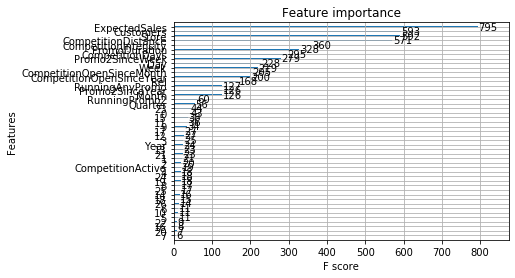